In [1]:
import pandas as pd

# Load the dataset
df = pd.read_csv("Sleep_health_and_lifestyle_dataset.csv")

# Check for initial NaN values
print(df.isnull().sum())

df.drop_duplicates()

# List of columns to drop
columns_to_drop = ["Occupation", "Sleep Duration", "Quality of Sleep", "BMI Category", "Daily Steps", "Sleep Disorder", "Person ID", "Gender"]

# Drop the columns from the DataFrame
df = df.drop(columns=columns_to_drop)

# Display the first few rows to confirm changes
df.head()

Person ID                    0
Gender                       0
Age                          0
Occupation                   0
Sleep Duration               0
Quality of Sleep             0
Physical Activity Level      0
Stress Level                 0
BMI Category                 0
Blood Pressure               0
Heart Rate                   0
Daily Steps                  0
Sleep Disorder             219
dtype: int64


,Age,Physical Activity Level,Stress Level,Blood Pressure,Heart Rate
0,27,42,6,126/83,77
1,28,60,8,125/80,75
2,28,60,8,125/80,75
3,28,30,8,140/90,85
4,28,30,8,140/90,85


In [2]:
# Split the "Blood Pressure" column into two separate columns
df[['Systolic BP', 'Diastolic BP']] = df['Blood Pressure'].str.split('/', expand=True)

# Convert the new columns to numeric values
df['Systolic BP'] = pd.to_numeric(df['Systolic BP'])
df['Diastolic BP'] = pd.to_numeric(df['Diastolic BP'])

# Drop the original "Blood Pressure" column
df = df.drop(columns=['Blood Pressure'])

print("Blood Pressure column fixed. Here's a preview:")
print(df.head())

Blood Pressure column fixed. Here's a preview:
   Age  Physical Activity Level  Stress Level  Heart Rate  Systolic BP  \
0   27                       42             6          77          126   
1   28                       60             8          75          125   
2   28                       60             8          75          125   
3   28                       30             8          85          140   
4   28                       30             8          85          140   

   Diastolic BP  
0            83  
1            80  
2            80  
3            90  
4            90  


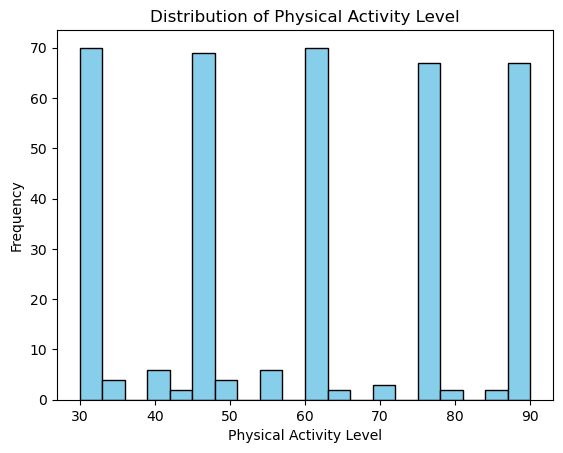

count    374.000000
mean      59.171123
std       20.830804
min       30.000000
25%       45.000000
50%       60.000000
75%       75.000000
max       90.000000
Name: Physical Activity Level, dtype: float64


In [3]:
import matplotlib.pyplot as plt

# Visualize the distribution
plt.hist(df['Physical Activity Level'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Physical Activity Level')
plt.xlabel('Physical Activity Level')
plt.ylabel('Frequency')
plt.show()

# Display basic statistics
print(df['Physical Activity Level'].describe())

In [4]:
low_threshold = df['Physical Activity Level'].quantile(0.33)
high_threshold = df['Physical Activity Level'].quantile(0.67)

print(f"Low threshold: {low_threshold}, High threshold: {high_threshold}")

# Update the labeling function
def label_activity(row):
    if row['Physical Activity Level'] <= low_threshold:
        return 'Low'
    elif low_threshold < row['Physical Activity Level'] <= high_threshold:
        return 'Good'
    else:
        return 'High'

# Apply the updated labeling function
df['Activity Level'] = df.apply(label_activity, axis=1)

# Verify the mapping
print(df[['Physical Activity Level', 'Activity Level']].head())

Low threshold: 45.0, High threshold: 75.0
   Physical Activity Level Activity Level
0                       42            Low
1                       60           Good
2                       60           Good
3                       30            Low
4                       30            Low


In [5]:
print(df['Activity Level'].value_counts())

Activity Level
Good    153
Low     150
High     71
Name: count, dtype: int64


In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical

# Features and target columns
features = ['Stress Level', 'Diastolic BP', 'Heart Rate']
target = 'Activity Level'

# Input (X) and target (y)
X = df[features].values
y = df[target].values

# Encode the target labels ('Low', 'Good', 'High') to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # 'Low' -> 0, 'Good' -> 1, 'High' -> 2
print("Class Mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

# Convert to one-hot encoding
num_classes = len(np.unique(y_encoded))
y_one_hot = to_categorical(y_encoded, num_classes=num_classes)

# Split data into training (70%), validation (15%), and testing (15%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_one_hot, test_size=0.3, random_state=42, stratify=y_encoded
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp.argmax(axis=1)
)

# Scale features using MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Verify shapes
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Class Mapping: {'Good': 0, 'High': 1, 'Low': 2}
Training set shape: (261, 3) (261, 3)
Validation set shape: (56, 3) (56, 3)
Test set shape: (57, 3) (57, 3)


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [8]:
# Build the neural network model
model = Sequential()

# Input layer (input_dim is the number of features, which is 3: Stress Level, Diastolic BP, and Heart Rate)
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))

# Add hidden layers
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))

# Output layer (3 classes: Low, Good, High)
model.add(Dense(num_classes, activation='softmax'))  # Using softmax for multi-class classification

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy',  # Multi-class classification loss
              metrics=['accuracy'])

# Show the model summary to check its architecture
model.summary()

/Users/elvisechefu/anaconda3/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,595 (25.76 KB)

 Trainable params: 6,595 (25.76 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Train the model
history = model.fit(X_train, y_train, 
                    epochs=50,  # Number of epochs; you can tune this as needed
                    batch_size=32,  # Batch size; you can adjust it depending on the dataset size
                    validation_data=(X_val, y_val),  # Validation data to monitor performance
                    verbose=1)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4083 - loss: 1.0884 - val_accuracy: 0.3929 - val_loss: 1.0731
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4584 - loss: 1.0725 - val_accuracy: 0.4821 - val_loss: 1.0616
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4549 - loss: 1.0577 - val_accuracy: 0.5179 - val_loss: 1.0477
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5259 - loss: 1.0331 - val_accuracy: 0.5179 - val_loss: 1.0329
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5075 - loss: 1.0190 - val_accuracy: 0.5179 - val_loss: 1.0130
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4908 - loss: 1.0141 - val_accuracy: 0.5179 - val_loss: 0.9901
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4941 - loss: 0.9861 - val_accuracy: 0.5179 - val_loss: 0.9686
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5475 - loss: 0.9496 - val_accuracy: 0.5357 - val_loss: 0.9426
Epoch 9

In [10]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.9825


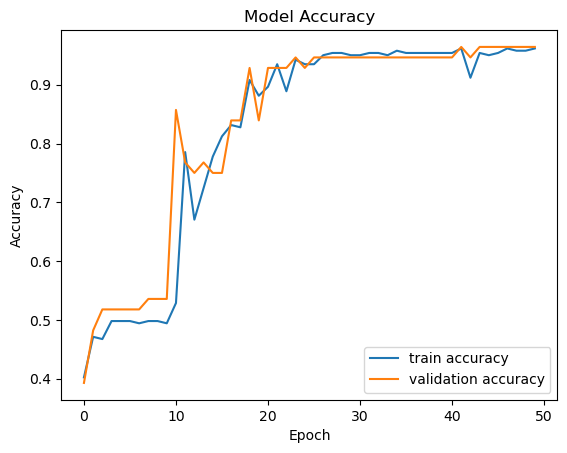

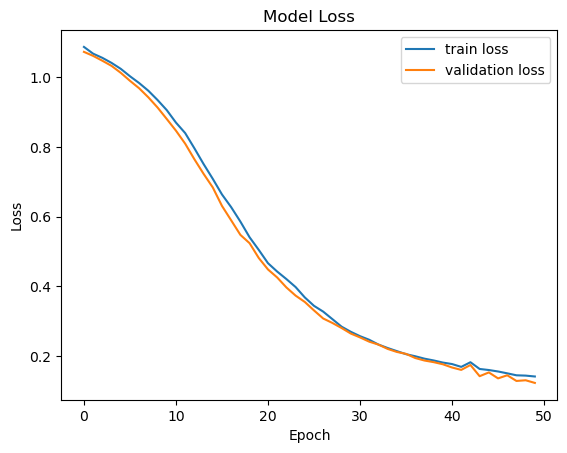

In [11]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

In [13]:
# Get predictions
y_pred = model.predict(X_test)
y_pred_labels = y_pred.argmax(axis=1)  # Get the class with the highest probability

# Convert true labels back to numeric values for comparison
y_true_labels = y_test.argmax(axis=1)

# Calculate Precision, Recall, and F1-Score for each class
precision = precision_score(y_true_labels, y_pred_labels, average=None)
recall = recall_score(y_true_labels, y_pred_labels, average=None)
f1 = f1_score(y_true_labels, y_pred_labels, average=None)

# Print the results
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Precision: [0.95833333 1.         1.        ]
Recall: [1.         1.         0.95652174]
F1 Score: [0.9787234  1.         0.97777778]


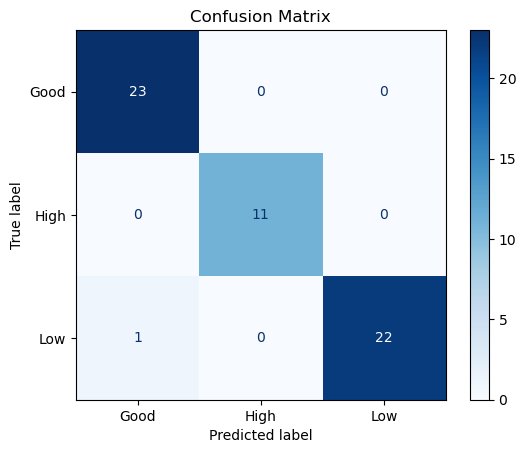

In [14]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

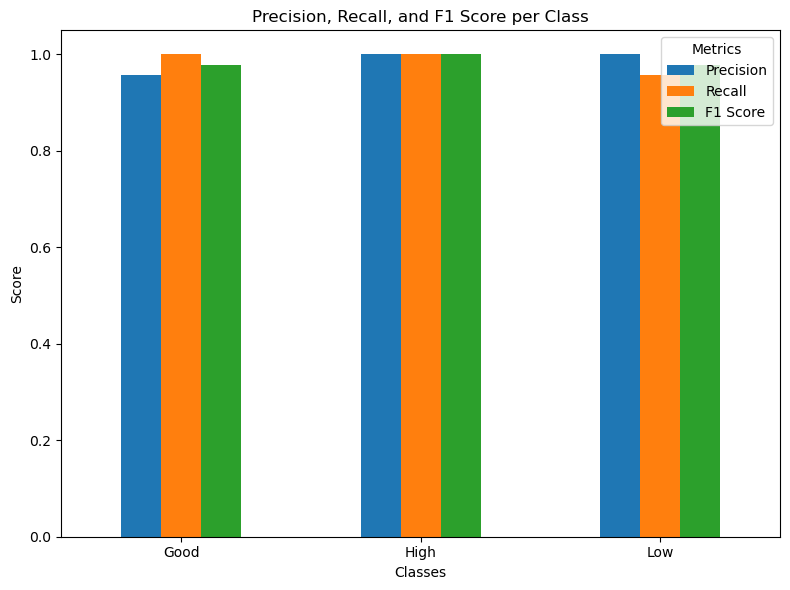

In [15]:
# Plot Precision, Recall, and F1 Score
metrics_df = pd.DataFrame({
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
}, index=label_encoder.classes_)

# Plot the metrics
metrics_df.plot(kind='bar', figsize=(8, 6))
plt.title('Precision, Recall, and F1 Score per Class')
plt.xlabel('Classes')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend(title='Metrics')
plt.tight_layout()
plt.show()

In [16]:
df.head(25)

,Age,Physical Activity Level,Stress Level,Heart Rate,Systolic BP,Diastolic BP,Activity Level
0,27,42,6,77,126,83,Low
1,28,60,8,75,125,80,Good
2,28,60,8,75,125,80,Good
3,28,30,8,85,140,90,Low
4,28,30,8,85,140,90,Low
5,28,30,8,85,140,90,Low
6,29,40,7,82,140,90,Low
7,29,75,6,70,120,80,Good
8,29,75,6,70,120,80,Good
9,29,75,6,70,120,80,Good


In [17]:
# Save the trained model
model.save('activity_level_model.h5')

# Save the scaler
import joblib
joblib.dump(scaler, 'scaler_FNN.pkl')

# Save the label encoder (for class labels)
import numpy as np
np.save('label_encoder_classes.npy', label_encoder.classes_)

In [18]:
import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import load_model

# Load the trained model and scaler
model = load_model('activity_level_model.h5')  # Load the trained neural network model
scaler = joblib.load('scaler_FNN.pkl')  # Load the scaler used during training

# Define the thresholds for 'Low', 'Good', and 'High' activity levels
low_threshold = 40  # Replace with the actual threshold from your training set
high_threshold = 80  # Replace with the actual threshold from your training set

# Define a function to categorize the prediction output (map output to activity levels)
def get_activity_level(prediction):
    if prediction <= low_threshold:
        return 'Low Activity Level'
    elif low_threshold < prediction <= high_threshold:
        return 'Good Activity Level'
    else:
        return 'High Activity Level'

# Example unseen data (replace with actual new data for testing)
new_data = pd.DataFrame({
    'Stress Level': [9],         # Example stress level
    'Diastolic BP': [90],        # Example diastolic blood pressure
    'Heart Rate': [90],          # Example heart rate
})

# Scale the new data using the scaler used during training (only the relevant features)
new_data_scaled = scaler.transform(new_data)

# Make prediction on the unseen data
predicted_activity = model.predict(new_data_scaled)

# Since we used a softmax activation, we'll get probabilities for each class.
# The predicted class will be the index of the highest probability
predicted_class = np.argmax(predicted_activity, axis=1)

# Convert the predicted class index to the corresponding activity level
activity_level = get_activity_level(predicted_class[0])

# Display the probabilities for each class and the predicted activity level
print(f"Predicted Probabilities: {predicted_activity[0]}")
print(f"Predicted Activity Level: {activity_level}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted Probabilities: [2.6380378e-04 9.9734871e-06 9.9972624e-01]
Predicted Activity Level: Low Activity Level


/Users/elvisechefu/anaconda3/anaconda3/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [20]:
import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import load_model

# Load the trained model and scaler
model = load_model('activity_level_model.h5')  # Load the trained neural network model
scaler = joblib.load('scaler_FNN.pkl')  # Load the scaler used during training

# Example unseen data (replace with actual new data for testing)
new_data = pd.DataFrame({
    'Stress Level': [3],         # Example stress level
    'Diastolic BP': [90],        # Example diastolic blood pressure
    'Heart Rate': [84],          # Example heart rate
})

# Scale the new data using the scaler used during training (only the relevant features)
new_data_scaled = scaler.transform(new_data)

# Make prediction on the unseen data
predicted_activity = model.predict(new_data_scaled)

# Display the raw probabilities for each class
print(f"Predicted Probabilities: {predicted_activity[0]}")

# Map the output probabilities to the activity level
activity_levels = ['Low Activity Level', 'Good Activity Level', 'High Activity Level']
predicted_class = np.argmax(predicted_activity, axis=1)

# Display the predicted class and the corresponding activity level
predicted_activity_level = activity_levels[predicted_class[0]]
print(f"Predicted Activity Level: {predicted_activity_level}")

/Users/elvisechefu/anaconda3/anaconda3/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted Probabilities: [0.01140424 0.98738015 0.00121561]
Predicted Activity Level: Good Activity Level
